<a href="https://colab.research.google.com/github/WEBSTERMASTER777/pdd/blob/add_first_commit_files/TripletLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!git clone -b add_first_commit_files https://github.com/WEBSTERMASTER777/pdd.git

Cloning into 'pdd'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 482 (delta 77), reused 80 (delta 37), pack-reused 350
Receiving objects: 100% (482/482), 162.30 KiB | 3.25 MiB/s, done.
Resolving deltas: 100% (291/291), done.


In [0]:
!ls 

gdrive	pdd  sample_data


In [0]:
pip install -r pdd/requirements.txt -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 92kB 3.1MB/s 
     |████████████████████████████████| 13.1MB 232kB/s 
     |████████████████████████████████| 20.4MB 46.6MB/s 
     |████████████████████████████████| 2.1MB 3.5MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
     |████████████████████████████████| 276kB 28.7MB/s 
     |████████████████████████████████| 6.7MB 27.8MB/s 
     |████████████████████████████████| 663.1MB 28kB/s 
     |████████████████████████████████| 8.8MB 3.0MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3-cp36-cp36m-linux_x86_64.whl size=44229 sha256=612dc45dce5ebabd3cba77ce0b13d73e6b544381925704107054add9992b1d6c
  Stored in directory: /root/.cache/pip/wheels/e4/76/4d/a95b8dd7b452b69e8ed4f68b69e1b55e12c9c9624dd962b191
Successfully built PyYAML
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.36.1 wh

In [0]:
from triplettorch import HardNegativeTripletMiner
from triplettorch import AllTripletMiner
from torch.utils.data import DataLoader
from triplettorch import TripletDataset

In [0]:
import numpy as np
import torch
import time
import os

from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2
from torchvision import transforms
from torch import nn
import random
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt

import torch.nn as nn
import numpy as np
import torch

import torch 
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cosine
from sklearn import metrics


RANDOM_SEED=13
CUDN_DETERMENISTIC=True
NUM_CLASSES=15
COUNT_NEIGHBOR_EXP_1=1
COUNT_NEIGHBOR_EXP_2=3
METRIC_KNN=cosine


In [0]:
!rm -r pdd

In [0]:
def fix_random_seed(seed, cudnn_determenistic=False):
    random.seed(seed);
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=cudnn_determenistic

In [0]:
fix_random_seed(RANDOM_SEED,CUDN_DETERMENISTIC)

In [0]:
!wget http://pdd.jinr.ru/archive_full.zip

--2020-04-29 14:30:44--  http://pdd.jinr.ru/archive_full.zip
Resolving pdd.jinr.ru (pdd.jinr.ru)... 159.93.223.250
Connecting to pdd.jinr.ru (pdd.jinr.ru)|159.93.223.250|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43711299 (42M) [application/zip]
Saving to: ‘archive_full.zip.1’

archive_full.zip.1  100%[===================>]  41.69M  13.3MB/s    in 3.1s    

2020-04-29 14:30:47 (13.3 MB/s) - ‘archive_full.zip.1’ saved [43711299/43711299]



KeyboardInterrupt: ignored

In [0]:
!unzip archive_full.zip -d pdd

Archive:  archive_full.zip
   creating: pdd/Wheat/
   creating: pdd/Wheat/Yellow rust/
  inflating: pdd/Wheat/Yellow rust/599.jpg  
  inflating: pdd/Wheat/Yellow rust/592.jpg  
  inflating: pdd/Wheat/Yellow rust/575.jpg  
  inflating: pdd/Wheat/Yellow rust/573.jpg  
  inflating: pdd/Wheat/Yellow rust/594.jpg  
  inflating: pdd/Wheat/Yellow rust/585.jpg  
  inflating: pdd/Wheat/Yellow rust/580.jpg  
  inflating: pdd/Wheat/Yellow rust/588.jpg  
  inflating: pdd/Wheat/Yellow rust/595.jpg  
  inflating: pdd/Wheat/Yellow rust/578.jpg  
  inflating: pdd/Wheat/Yellow rust/587.jpg  
  inflating: pdd/Wheat/Yellow rust/596.jpg  
  inflating: pdd/Wheat/Yellow rust/572.jpg  
  inflating: pdd/Wheat/Yellow rust/583.jpg  
  inflating: pdd/Wheat/Yellow rust/598.jpg  
  inflating: pdd/Wheat/Yellow rust/584.jpg  
  inflating: pdd/Wheat/Yellow rust/589.jpg  
  inflating: pdd/Wheat/Yellow rust/581.jpg  
  inflating: pdd/Wheat/Yellow rust/593.jpg  
  inflating: pdd/Wheat/Yellow rust/591.jpg  
  inflating: 

In [0]:
!ls pdd

Corn  Cotton  Grape  Wheat


In [0]:
import numpy as np
import os

from torch.utils.data import Dataset
from torch.utils.data import Sampler
from torchvision.datasets import ImageFolder


class AllCropsDataset(Dataset):
    def __init__(self, image_folder, subset='', transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        # data subset (train, test)
        self.subset = subset
        # store each crop data
        self.datasets = []
        self.crops = []
        self.samples = []
        self.imgs = []
        self.classes = []
        self.targets = []
        self.class_to_idx = {}
        # iterate over all folders 
        # with all crops
        for i, d in enumerate(os.listdir(image_folder)):
            self.crops.append(d)
            # full path to the folder
            d_path = os.path.join(image_folder, d, self.subset)
            # attribute name to set attribute 
            attr_name = '%s_ds' % d.lower()
            print("Load '%s' data" % attr_name)
            # set the attribute with the specified name
            setattr(self, attr_name, ImageFolder(d_path))
            # add the dataset to datasets list
            self.datasets.append(getattr(self, attr_name))
            # get dataset attribute
            ds = getattr(self, attr_name)
            # add attr targets to the global targets
            ds_targets = [x+len(self.classes) for x in ds.targets]
            self.targets.extend(ds_targets)
            # add particular classes to the global classes' list
            ds_classes = []
            for c in ds.classes:
                new_class = '__'.join([d, c])
                self.class_to_idx[new_class] = len(self.classes) + ds.class_to_idx[c]
                ds_classes.append(new_class)
            self.classes.extend(ds_classes)
            # imgs attribute has form (file_path, target)
            ds_imgs, _ = zip(*ds.imgs)
            # images and samples are equal
            self.imgs.extend(list(zip(ds_imgs, ds_targets)))
            self.samples.extend(list(zip(ds_imgs, ds_targets)))
            
            
    def __len__(self):
        return len(self.samples)
      
      
    def __getitem__(self, idx):
        path, target = self.samples[idx]
        img = self.datasets[0].loader(path)
        
        if self.transform is not None:
            img = self.transform(img)
        
        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return img, target
      
      
    

In [0]:
DATA_PATH = 'pdd'

def prepare_datasets():
    train_ds = AllCropsDataset(
        DATA_PATH, 
        subset='train',
        transform=transforms.Compose([
            transforms.Resize(256),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            # transforms.Normalize([0.4352, 0.5103, 0.2836], [0.2193, 0.2073, 0.2047])]),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
          target_transform=torch.tensor)

    test_ds = AllCropsDataset(
        DATA_PATH, 
        subset='test',
        transform=transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        target_transform=torch.tensor)

    # print statistics
    print('Train size:', len(train_ds))
    print('Test size:', len(test_ds))
    print('Number of samples in the dataset:', len(train_ds))
    print('Crops in the dataset:', train_ds.crops)
    print('Total number of classes in the dataset:', len(train_ds.classes))
    print('Classes with the corresponding targets:')
    print(train_ds.class_to_idx)
    return train_ds, test_ds

In [0]:
import numpy as np
import shutil
import os

from glob import glob
from tqdm import tqdm
from tqdm.notebook import tqdm

TEST_SIZE = 0.2
RS = 42
def _remove_path_if_exists(path):
    if os.path.exists(path):
        if os.path.isfile(path):
            os.remove(path)
        else:
            shutil.rmtree(path)

def _makedir_and_copy2(path, dirname, fnames):
    path_for_saving_files = os.path.join(path, dirname)
    os.makedirs(path_for_saving_files)

    for fname in fnames:
        shutil.copy2(fname, path_for_saving_files)

def datadir_train_test_split(origin_path, test_size, random_state=0):
    """Splits the data in directory on train and test.
    # Arguments
        origin_path: path to the original directory
        test_size: the size of test data fraction
    # Returns
        Tuple of paths: `(train_path, test_path)`.
    """
    print("\n\nSplit `%s` directory" % origin_path)
    print("Test size: %.2f" % test_size)
    print("Random state: {}".format(random_state))
    train_path = os.path.join(origin_path, 'train')
    test_path = os.path.join(origin_path, 'test')   
    _remove_path_if_exists(train_path)
    _remove_path_if_exists(test_path)

    try:
        subfolders = glob(os.path.join(origin_path, "*", ""))
        # if train/test split is already done
        if set(subfolders) == set(['train', 'test']):
            return (train_path, test_path)
        # if train/test split is required
        # recreate train/test folders
        os.makedirs(train_path)
        os.makedirs(test_path)

        for folder in tqdm(subfolders, total=len(subfolders), ncols=57):
            # collect all images
            img_fnames = []
            for ext in ["*.jpg", "*.png", "*jpeg"]:
                img_fnames.extend(
                    glob(os.path.join(folder, ext)))
            # set random state parameter
            rs = np.random.RandomState(random_state)
            # shuffle array
            rs.shuffle(img_fnames)
            # split on train and test
            n_test_files = int(len(img_fnames)*test_size)
            test_img_fnames = img_fnames[:n_test_files]
            train_img_fnames = img_fnames[n_test_files:]
            # copy train files into `train_path/folder`
            folder_name = os.path.basename(os.path.dirname(folder))
            _makedir_and_copy2(train_path, folder_name, train_img_fnames)
            # copy test files into `test_path/folder`
            _makedir_and_copy2(test_path, folder_name, test_img_fnames)

        for folder in subfolders:
            shutil.rmtree(folder)

    except:
        _remove_path_if_exists(train_path)
        _remove_path_if_exists(test_path)
        raise 
        
    return (train_path, test_path)

In [0]:
def split_on_train_and_test(random_seed):
    for crop in os.listdir('pdd'):
        crop_path = os.path.join('pdd', crop)
        _ = datadir_train_test_split(crop_path, 
                                    test_size=0.2, 
                                    random_state=random_seed)

In [0]:
!ls pdd -a

.  ..  Corn  Cotton  Grape  Wheat


In [0]:
split_on_train_and_test(RANDOM_SEED)



Split `pdd/Cotton` directory
Test size: 0.20
Random state: 12





Split `pdd/Corn` directory
Test size: 0.20
Random state: 12





Split `pdd/Grape` directory
Test size: 0.20
Random state: 12





Split `pdd/Wheat` directory
Test size: 0.20
Random state: 12


In [0]:
!ls pdd -a

.  ..  Corn  Cotton  Grape  Wheat


In [0]:
# !rm -r ./pdd/.ipynb_checkpoints

In [0]:
train_ds, test_ds = prepare_datasets()

Load 'cotton_ds' data
Load 'corn_ds' data
Load 'grape_ds' data
Load 'wheat_ds' data
Load 'cotton_ds' data
Load 'corn_ds' data
Load 'grape_ds' data
Load 'wheat_ds' data
Train size: 620
Test size: 147
Number of samples in the dataset: 620
Crops in the dataset: ['Cotton', 'Corn', 'Grape', 'Wheat']
Total number of classes in the dataset: 20
Classes with the corresponding targets:
{'Cotton__Alternaria leaf blight': 0, 'Cotton__Healthy': 1, 'Cotton__Nutrient deficiency': 2, 'Cotton__Powdery mildew': 3, 'Cotton__Verticillium wilt': 4, 'Corn__Downy mildew': 5, 'Corn__Eyespot': 6, 'Corn__Healthy': 7, 'Corn__Northern leaf blight': 8, 'Corn__Southern rust': 9, 'Grape__Black rot': 10, 'Grape__Chlorosis': 11, 'Grape__Esca': 12, 'Grape__Healthy': 13, 'Grape__Powdery mildew': 14, 'Wheat__Black chaff': 15, 'Wheat__Brown rust': 16, 'Wheat__Healthy': 17, 'Wheat__Powdery mildew': 18, 'Wheat__Yellow rust': 19}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


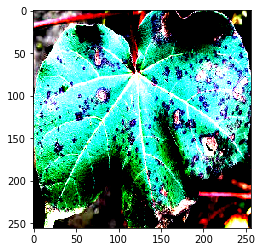

In [0]:
plt.imshow(train_ds[12][0].permute(1,2,0))

# Model

In [0]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2


class PDDModel(nn.Module):
    def __init__(self, embedding_size, num_classes, pretrained=False):
        super (PDDModel, self).__init__()
        
        self.model = mobilenet_v2(pretrained)
        self.embedding_size = embedding_size
        self.model.fc = nn.Linear(1280*8*8, self.embedding_size)
        self.model.classifier = nn.Linear(self.embedding_size, num_classes)
    
    
    def l2_norm(self, input):
        input_size = input.size()
        buffer = torch.pow(input, 2)
        normp = torch.sum(buffer, 1).add_(1e-10)
        norm = torch.sqrt(normp)
        _output = torch.div(input, norm.view(-1, 1).expand_as(input))
        output = _output.view(input_size)
    
        return output
    
    
    def forward(self, x):
        x = self.model.features(x)
        x = x.view(x.size(0), -1)
        x = self.model.fc(x)    
        self.features = self.l2_norm(x)
        alpha = 10
        self.features = self.features*alpha
        
        return self.features
    
    
    def forward_classifier(self, x):
        features = self.forward(x)
        res = self.model.classifier(features)
        
        return res

# Build model

In [0]:
NUM_CLASSES = len(train_ds.classes)

fix_random_seed(RANDOM_SEED, CUDN_DETERMENISTIC)
model=PDDModel(1280,NUM_CLASSES,True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss = torch.nn.NLLLoss()
# model.load_state_dict(torch.load('triplet.pt'))
# model.load_state_dict(torch.load('triplet_exp1.pt'))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 60.4MB/s]


# Цикл Train

In [0]:
import copy
import torch.optim as optim
# Create Lambda function to access data in correct format
train_set_d    = lambda index: train_ds[ index ][0].float( ).numpy( )
test_set_d     = lambda index:  test_ds[ index ][0].float( ).numpy( )

# Hyperparameters
epochs         = 3000
batch_size     = 8
n_sample       = 4

fix_random_seed(RANDOM_SEED, CUDN_DETERMENISTIC)

# Triplet Dataset Definition
tri_train_set  = TripletDataset( torch.FloatTensor(train_ds.targets).numpy( ), train_set_d, len(train_ds), n_sample )
tri_test_set   = TripletDataset(  torch.FloatTensor(test_ds.targets),  test_set_d,  len(test_ds),        1 )

# Data Loader
tri_train_load = DataLoader( tri_train_set,
    batch_size  = batch_size,
    shuffle     = True,
    num_workers = 2,
    pin_memory  = True
)
tri_test_load  = DataLoader( tri_test_set,
    batch_size  = batch_size,
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True
)

miner=AllTripletMiner( .5 ).cuda( ) #HardNegativeTripletMiner( .4).cuda( ) # 

# Выделение в np array

In [0]:
def forward_inputs_into_model(loader, model, device,batchsize):
    X = []
    y = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).detach().cpu().numpy()
                targets= targets.detach().cpu().numpy()
                if (outputs.shape[0]==batchsize):
                    X.append(outputs)
                    y.append(targets)
    return np.vstack(X), np.hstack(y)  

# Функция график

In [0]:
classes=test_ds.classes
def plot(embeddings,labels,classes_name,classes_count,name):
  plt.figure(figsize=(10,10))
  
  for i in range(classes_count):
      inds = np.where(labels==i)[0]
      plt.scatter(embeddings[inds,0],embeddings[inds,1])
  plt.legend(classes_name,loc='center left', bbox_to_anchor=(1, 0.5),prop={"size":25})
  plt.title(name,fontsize=30)
  plt.show()

# Метрики

In [0]:
def knn_acc(test_em,test_labels,train_em,train_labels,n_neighbors,metric):
          knn=KNeighborsClassifier(n_neighbors,metric=metric)
          knn.fit(train_em,train_labels)
          y_pred=knn.predict(test_em)
          msg=f'Knn acc: {metrics.accuracy_score(test_labels,y_pred)} count neighbors: {n_neighbors}'
          print(msg)

# Сохранение модели

In [0]:
import pickle
def save_model(model,optimizer):
          torch.save(model.state_dict(),'triplet_exp1.pt')   
          torch.save(optimizer.state_dict,'optim.pt')
          torch.save(model,'triplet_model.pt')
          # save the model to disk
          filename = 'finalized_model.sav'
          pickle.dump(model, open(filename, 'wb'))         

In [0]:
loss_history=[]
class TripletTrainer(object):
      def __init__(self,
                   model, 
                   optimizer, 
                   tri_train_load,
                   epochs, 
                   tri_test_load,
                   batch_size,
                   KNN_train_data_load,
                   KNN_test_data_load,
                   scheduler
                   ):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.optimizer = optimizer
        # self.loss = loss
        self.epochs = epochs
        self.tri_train_load=tri_train_load
        self.tri_test_load=tri_test_load
        self.batch_size=batch_size
        self.train_loader=KNN_train_data_load
        self.test_loader=KNN_test_data_load
#         self.scheduler=scheduler
        self.loss_history=loss_history


      def train(self):
        for e in tqdm( range( self.epochs ), desc = 'Epoch' ):
            
            test_em,test_labels=forward_inputs_into_model(self.test_loader,self.model,
                                                          self.device,self.batch_size)
            train_em,train_labels=forward_inputs_into_model(self.train_loader,self.model,
                                                            self.device,self.batch_size)
            knn_acc(test_em,test_labels,train_em,train_labels,COUNT_NEIGHBOR_EXP_1,METRIC_KNN)
            knn_acc(test_em,test_labels,train_em,train_labels,COUNT_NEIGHBOR_EXP_2,METRIC_KNN)
            
            plot(train_em,train_labels,classes,NUM_CLASSES,'train_embeddings')
            plot(test_em,test_labels,classes,NUM_CLASSES,'test_embeddings')
            self.train_phase()
            self.validating_phase()
            
            if e % 5 == 0 and e > 0:
                save_model(self.model,self.optimizer)          

      
      def train_phase(self):
        # ================== TRAIN ========================
            train_n        = len( self.tri_train_load )
            train_loss     = 0.
            train_frac_pos = 0.

            

            self.model.train()
            with tqdm( self.tri_train_load, desc = 'Batch' ) as b_pbar:
                for b, batch in enumerate( b_pbar ):
                    self.optimizer.zero_grad()

                    labels, data = batch
                    labels= torch.cat( [ label for label in labels ], axis = 0 )
                    data= torch.cat( [ datum for datum in   data ], axis = 0 )
                    labels= labels.cuda()
                    data= data.cuda()

                    embeddings=model(data)
                    loss, frac_pos=miner(labels, embeddings)
                    loss.backward( )
                    self.optimizer.step()
                    train_loss+= loss.detach( ).item( )
                    train_frac_pos += frac_pos.detach( ).item( ) if frac_pos is not None else \
                                      0.

                    b_pbar.set_postfix(
                        train_loss     = train_loss / train_n,
                        train_frac_pos = f'{( train_frac_pos / train_n ):.2%}'
                    )

      def validating_phase(self):
          val_n        = len( tri_test_load )
          val_loss     = 0.
          val_frac_pos = 0.
          self.model.eval()
          with tqdm( tri_test_load, desc = 'val' ) as b_pbar:
            for b, batch in enumerate( b_pbar ):
              labels, data = batch
              labels= torch.cat( [ label for label in labels ], axis = 0 )
              data= torch.cat( [ datum for datum in   data ], axis = 0 )
              labels= labels.cuda()
              data= data.cuda()
              embeddings=model(data)
              loss, frac_pos=miner(labels, embeddings)
              val_loss+= loss.detach().item()
              loss_history.append(val_loss)
              val_frac_pos += frac_pos.detach().item() if frac_pos is not None else \
                                    0.
              b_pbar.set_postfix(
                      val_loss     = val_loss / val_n,
                      val_frac_pos = f'{( val_frac_pos / val_n ):.2%}'
                  )                             

In [0]:
train_ds, test_ds = prepare_datasets() 
fix_random_seed(RANDOM_SEED, CUDN_DETERMENISTIC)
train_loader = torch.utils.data.DataLoader(train_ds, pin_memory=True, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, pin_memory=True, batch_size=batch_size, shuffle=True, num_workers=2)

Load 'cotton_ds' data
Load 'corn_ds' data
Load 'grape_ds' data
Load 'wheat_ds' data
Load 'cotton_ds' data
Load 'corn_ds' data
Load 'grape_ds' data
Load 'wheat_ds' data
Train size: 620
Test size: 147
Number of samples in the dataset: 620
Crops in the dataset: ['Cotton', 'Corn', 'Grape', 'Wheat']
Total number of classes in the dataset: 20
Classes with the corresponding targets:
{'Cotton__Alternaria leaf blight': 0, 'Cotton__Healthy': 1, 'Cotton__Nutrient deficiency': 2, 'Cotton__Powdery mildew': 3, 'Cotton__Verticillium wilt': 4, 'Corn__Downy mildew': 5, 'Corn__Eyespot': 6, 'Corn__Healthy': 7, 'Corn__Northern leaf blight': 8, 'Corn__Southern rust': 9, 'Grape__Black rot': 10, 'Grape__Chlorosis': 11, 'Grape__Esca': 12, 'Grape__Healthy': 13, 'Grape__Powdery mildew': 14, 'Wheat__Black chaff': 15, 'Wheat__Brown rust': 16, 'Wheat__Healthy': 17, 'Wheat__Powdery mildew': 18, 'Wheat__Yellow rust': 19}


In [0]:
fix_random_seed(RANDOM_SEED, CUDN_DETERMENISTIC)
trainer = TripletTrainer(model=model,
                         optimizer=optimizer,
                         tri_train_load=tri_train_load,
                         epochs=5000,
                         tri_test_load=tri_test_load,
                         batch_size=batch_size,
                         KNN_train_data_load=train_loader,
                         KNN_test_data_load=test_loader,
                         scheduler=scheduler)
trainer.train()                     

In [0]:
torch.cuda.empty_cache() 

In [0]:
!rm -r pdd

In [0]:
!git clone -b add_first_commit_files https://github.com/WEBSTERMASTER777/pdd.git

Cloning into 'pdd'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 482 (delta 77), reused 80 (delta 37), pack-reused 350
Receiving objects: 100% (482/482), 162.30 KiB | 1.28 MiB/s, done.
Resolving deltas: 100% (291/291), done.


In [0]:
# cd ..

In [0]:
!ls

archive_full.zip     gdrive    pdd	    triplet_exp1.pt
finalized_model.sav  optim.pt  sample_data  triplet_model.pt


In [0]:
!pip install torchbearer

     |████████████████████████████████| 143kB 3.4MB/s 


#Классификатор персептрон

#Data utils

In [0]:
def get_trained_model(model, feature_extractor, device):
    model.load_state_dict(
        torch.load(
            feature_extractor,
            map_location=device))
    model.eval()
    return model

def forward_inputs_into_model(loader, model, device, batch_size):
    X = []
    y = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            if (outputs.shape[0] == batch_size):
                X.append(outputs)
                y.append(targets)
    return np.vstack(X), np.hstack(y)


def save_model(model, optimizer, model_save_path, optim_save_path):
    torch.save(model.state_dict(), model_save_path)
    torch.save(optimizer.state_dict, optim_save_path)

class Perceptron_classifier(nn.Module):
    def __init__(self, emmbeding_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(1280, 512)
        self.fc2 = nn.Linear(512, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # return x
        return F.log_softmax(x, dim=1)

#Config

In [0]:
RANDOM_SEED=12
CUDN_DETERMENISTIC=True
BATCH_SIZE=32
FEATURE_EXTRACTOR='triplet_exp1.pt'
CLASSIFIER='classifier.pt'



# Обучение персептрона

In [0]:
import torch
import torch.nn as nn
from torchbearer import Trial
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn.functional as F
from torchbearer.callbacks import Best


def train_classifier(model, optimizer, criterion, metrics, train_em, train_labels, test_em, test_labels):
    # optimizer = Adam(model.parameters())
    checkpoint = Best('classifier.pt', monitor='val_acc', mode='max', save_model_params_only=True)
    trial = Trial(model, callbacks=[checkpoint], optimizer=optimizer, criterion=criterion, metrics=['acc'])
    trial.with_train_data(torch.Tensor(train_em), torch.Tensor(train_labels).long()).with_val_data(torch.Tensor(test_em), torch.Tensor(test_labels).long()).for_steps(100).run(40)


def main():
    device = 'cpu'
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        pin_memory=True,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        test_ds,
        pin_memory=True,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2)

    modelpdd = PDDModel(1280, NUM_CLASSES, True)
    modelpdd.to(device)
    modelclassifier = Perceptron_classifier(1280, NUM_CLASSES)
    modelclassifier.to(device)
    modelpdd = get_trained_model(modelpdd, FEATURE_EXTRACTOR, device)
    test_em, test_labels = forward_inputs_into_model(test_loader, modelpdd,
                                                             device, BATCH_SIZE)
    train_em, train_labels = forward_inputs_into_model(train_loader, modelpdd,
                                                               device, BATCH_SIZE)

    optimizer = Adam(modelclassifier.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_classifier(modelclassifier, optimizer, criterion, ['acc'], train_em, train_labels, test_em, test_labels)


if __name__ == "__main__":

    main()


In [0]:
!ls

archive_full.zip    classifier.pt	 my_path.pt  sample_data
archive_full.zip.1  finalized_model.sav  optim.pt    triplet_exp1.pt
classifieroptim.pt  gdrive		 pdd	     triplet_model.pt


In [0]:
fix_random_seed(RANDOM_SEED, CUDN_DETERMENISTIC)
train_loader = torch.utils.data.DataLoader(train_ds, pin_memory=True, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, pin_memory=True, batch_size=batch_size, shuffle=True, num_workers=2)

In [0]:
import torch.nn as nn
from collections import OrderedDict
import torch


def get_trace_model(embedding_model_path, classifier_model_path, save_path, device, num_classes):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    embedding_model = PDDModel(1280, num_classes, True)
    classifier_model = Perceptron_classifier(1280, num_classes)
    model = nn.Sequential(OrderedDict([
            ('embedding', get_trained_model(embedding_model, embedding_model_path, device)),
            ('classifier', get_trained_model(classifier_model, classifier_model_path, device)),
    ]))
    scripted_model = torch.jit.trace(model, torch.rand(1,3,256,256))
    scripted_model.save(save_path)


def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    get_trace_model(FEATURE_EXTRACTOR, CLASSIFIER, 'trace_model.pt', device, NUM_CLASSES)


if __name__ == "__main__":

    main()

In [0]:
!ls

archive_full.zip    classifier.pt	 my_path.pt  sample_data
archive_full.zip.1  finalized_model.sav  optim.pt    triplet_exp1.pt
classifieroptim.pt  gdrive		 pdd	     triplet_model.pt


In [0]:
f=open('classes2.txt','w')
s1='\n'.join(train_ds.classes)
f.write(s1)
f.close()

In [0]:
cat classes2.txt.txt

Wheat__Black chaff
Wheat__Brown rust
Wheat__Healthy
Wheat__Powdery mildew
Wheat__Yellow rust
Grape__Black rot
Grape__Chlorosis
Grape__Esca
Grape__Healthy
Grape__Powdery mildew
Cotton__Alternaria leaf blight
Cotton__Healthy
Cotton__Nutrient deficiency
Cotton__Powdery mildew
Cotton__Verticillium wilt
Corn__Downy mildew
Corn__Eyespot
Corn__Healthy
Corn__Northern leaf blight
Corn__Southern rust